In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import os
from contextlib import redirect_stdout
import ssl

import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

# Datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dir_path = '../data/processed/BUSI/'

if os.path.exists(train_dir_path + '.DS_Store'):
    os.remove(train_dir_path + '.DS_Store')

image_paths = [os.path.join(train_dir_path, img) for img in os.listdir(train_dir_path)]

mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)

for img_path in image_paths:
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img)
    mean_sum += img_tensor.mean(dim=(1, 2))
    std_sum += img_tensor.std(dim=(1, 2))

mean = mean_sum / len(image_paths)
std = std_sum / len(image_paths)

mean = mean.tolist()
std = std.tolist()

print("Mean:", mean)
print("Standard deviation:", std)


Mean: [0.32753363251686096, 0.3275355100631714, 0.3275183141231537]
Standard deviation: [0.20394660532474518, 0.20394884049892426, 0.20393770933151245]


In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class BUSI(Dataset):
    def __init__(self, root_dir, transform=None, train_percentage=0.8, vali_percentage=0.1, test_percentage=0.2):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

        self.test_percentage = test_percentage # 20%
        self.train_percentage = train_percentage * (1 - vali_percentage) # 72%
        self.vali_percentage = train_percentage - self.train_percentage # 8%

        self._filter_files()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = pil_loader(img_name)
        label = self._get_label(img_name)
        if self.transform:
            image = self.transform(image)
        return image, label

    def _get_label(self, filename):
        if 'normal' in filename:
            label = 0
        elif 'benign' in filename:
            label = 1
        elif 'malignant' in filename:
            label = 2
        return label

    def _filter_files(self):
        normal_files = [f for f in self.image_files if 'normal' in f]
        benign_files = [f for f in self.image_files if 'benign' in f]
        malignant_files = [f for f in self.image_files if 'malignant' in f]

        train_normal_count = int(len(normal_files) * self.train_percentage)
        train_benign_count = int(len(benign_files) * self.train_percentage)
        train_malignant_count = int(len(malignant_files) * self.train_percentage)

        vali_normal_count = int(len(normal_files) * self.vali_percentage)
        vali_benign_count = int(len(benign_files) * self.vali_percentage)
        vali_malignant_count = int(len(malignant_files) * self.vali_percentage)

        test_normal_count = int(len(normal_files) * self.test_percentage)
        test_benign_count = int(len(benign_files) * self.test_percentage)
        test_malignant_count = int(len(malignant_files) * self.test_percentage)

        normal_files = normal_files[:train_normal_count]
        benign_files = benign_files[:train_benign_count]
        malignant_files = malignant_files[:train_malignant_count]

        self.train_files = normal_files + benign_files + malignant_files

        normal_files = normal_files[:test_normal_count]
        benign_files = benign_files[:test_benign_count]
        malignant_files = malignant_files[:test_malignant_count]

        self.test_files = normal_files + benign_files + malignant_files

        normal_files = normal_files[:vali_normal_count]
        benign_files = benign_files[:vali_benign_count]
        malignant_files = malignant_files[:vali_malignant_count]

        self.vali_files = normal_files + benign_files + malignant_files


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

BUSIDataset = BUSI(root_dir=train_dir_path, transform=transform, train_percentage=0.8, vali_percentage=0.1)

In [4]:
len(BUSIDataset.image_files)

649

In [5]:
len(BUSIDataset.train_files)

466

In [6]:
len(BUSIDataset.vali_files)

50

In [7]:
len(BUSIDataset.test_files)

129

In [8]:
train_loader = DataLoader(BUSIDataset, batch_size=16, sampler=SubsetRandomSampler(range(len(BUSIDataset.train_files))))
vali_loader = DataLoader(BUSIDataset, batch_size=16, sampler=SubsetRandomSampler(range(len(BUSIDataset.vali_files))))
test_loader = DataLoader(BUSIDataset, batch_size=16, sampler=SubsetRandomSampler(range(len(BUSIDataset.test_files))))

In [9]:
train_loader.dataset

# Loading & Modifying ResNet-101 Model

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

with redirect_stdout(None):
    model.eval()

Using cache found in /Users/ahmedmahmoud/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
num_features = model.fc.in_features
num_features

2048

In [12]:
num_classes = 3
new_fc_layers = [
    torch.nn.Linear(num_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
]
model.fc = torch.nn.Sequential(*new_fc_layers)

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [28]:
model = model.to('mps')

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('mps'), labels.to('mps')
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in vali_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(vali_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Validation Loss: 0.2862, Validation Accuracy: 96.00%
Epoch [2/10], Validation Loss: 0.0837, Validation Accuracy: 98.00%
Epoch [3/10], Validation Loss: 0.0141, Validation Accuracy: 100.00%
Epoch [4/10], Validation Loss: 0.0212, Validation Accuracy: 98.00%
Epoch [5/10], Validation Loss: 0.0055, Validation Accuracy: 100.00%
Epoch [6/10], Validation Loss: 0.0362, Validation Accuracy: 100.00%
Epoch [7/10], Validation Loss: 0.0045, Validation Accuracy: 100.00%
Epoch [8/10], Validation Loss: 0.0013, Validation Accuracy: 100.00%
Epoch [9/10], Validation Loss: 0.0012, Validation Accuracy: 100.00%
Epoch [10/10], Validation Loss: 0.0016, Validation Accuracy: 100.00%


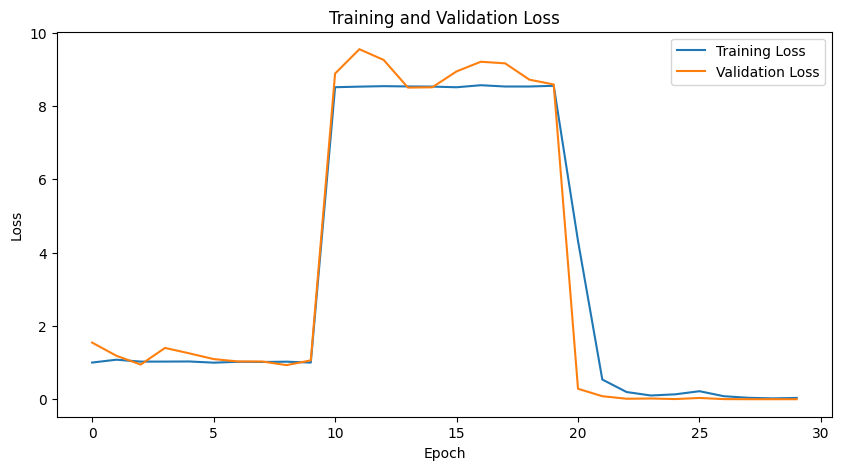

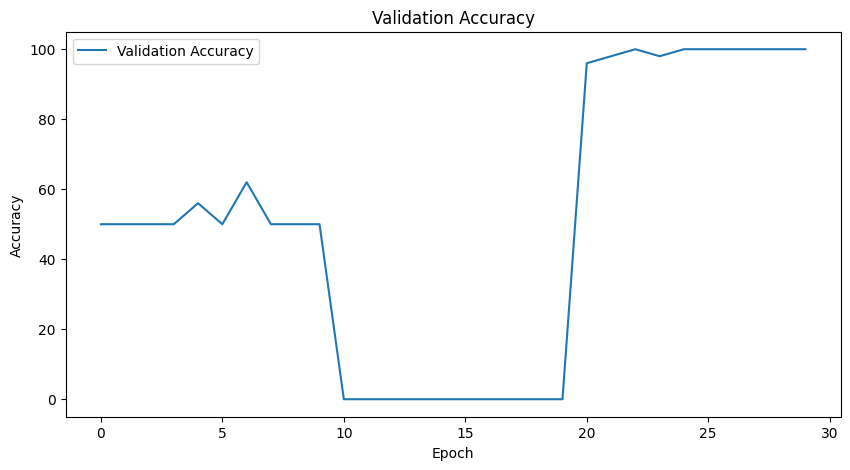

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [30]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('mps'), labels.to('mps')
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0036, Test Accuracy: 100.00%


In [34]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class DatasetB(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = pil_loader(img_name)
        label = self._get_label(img_name)
        if self.transform:
            image = self.transform(image)
        return image, label

    def _get_label(self, filename):
        if 'normal' in filename:
            label = 0
        elif 'benign' in filename:
            label = 1
        elif 'malignant' in filename:
            label = 2
        return label

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_ds = DatasetB(root_dir='../data/processed/Dataset (B)/', transform=transform)

test_loader2 = DataLoader(test_ds, batch_size=16)

In [35]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader2:
        inputs, labels = inputs.to('mps'), labels.to('mps')
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader2)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 2.4299, Test Accuracy: 55.83%
